In [2]:
import numpy as np
import mlrose_hiive
import pandas as pd
# Import sklearn 
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
# Plotting tools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# Misc tools
import time

In [3]:
# Make the figures bigger
plt.rcParams.update({'font.size': 20})

In [4]:
# Import the dataset
# Load the data
heart_df = pd.read_csv('./heart_2.csv')
heart_X = heart_df.drop(columns =['target'])
heart_y = heart_df['target']

# Split the data into 30:70 ratio
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(heart_X, heart_y,
                                                    test_size = 0.3, random_state = 42, stratify = heart_y
                                                   )

# From before we should perform some scaling first
# We will be using a min max scaler to scale the data
scaler = MinMaxScaler()
scaler.fit(X_train_heart)
X_train_heart = scaler.transform(X_train_heart)
X_test_heart = scaler.transform(X_test_heart)

In [5]:
%%time
grid_search_parameters = ({
  'learning_rate': [0.001, 0.1, 0.5],
  'restarts': [5],
  'activation': [mlrose_hiive.neural.activation.relu],
})
rhc_nn = mlrose_hiive.NNGSRunner(X_train_heart, y_train_heart, 
                                 X_test_heart, y_test_heart, 
                                 experiment_name= "NeuralNetworkRHC",
                                 output_directory="nn_rhc_algorithm/",
                                 seed=42, iteration_list =[10], 
                                 algorithm=mlrose_hiive.random_hill_climb,
                                 hidden_layer_sizes=[[100, 100]],
                                 grid_search_parameters=grid_search_parameters,
                                 grid_search_scorer_method=f1_score,
                                 early_stopping = True,
                                 max_attempts =100,
                                 generate_curves = True,
                                 n_jobs=-1,
                                 cv=5
                                )
run_stats, curves, cv_results, best_est = rhc_nn.run()

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Wall time: 2min 48s


In [62]:
best_est.best_params_

{'activation': <function mlrose_hiive.neural.activation.relu.relu(x, deriv=False)>,
 'hidden_layer_sizes': [100, 100],
 'learning_rate': 0.001,
 'restarts': 5}

fit_time = 1877.2248222827911
              precision    recall  f1-score   support

           0       0.53      0.60      0.56       150
           1       0.57      0.50      0.53       158

    accuracy                           0.55       308
   macro avg       0.55      0.55      0.55       308
weighted avg       0.55      0.55      0.55       308

              precision    recall  f1-score   support

           0       0.56      0.57      0.56       349
           1       0.58      0.57      0.57       368

    accuracy                           0.57       717
   macro avg       0.57      0.57      0.57       717
weighted avg       0.57      0.57      0.57       717

Wall time: 50min 51s


Text(0, 0.5, 'Loss')

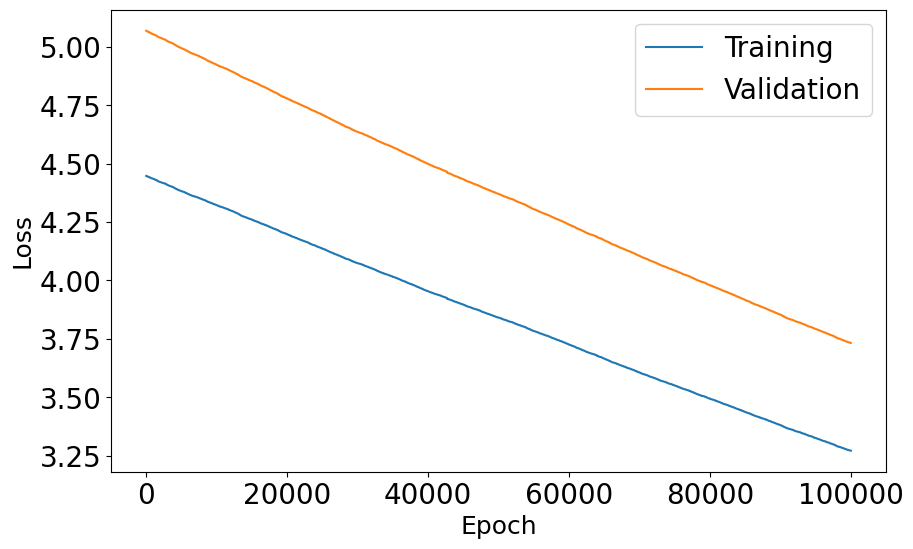

In [120]:
%%time
rhc_nn_epochs = mlrose_hiive.NeuralNetwork(
    hidden_nodes = [100,100], activation = 'relu', 
    algorithm = 'random_hill_climb', 
    max_iters=100000,
    learning_rate =  0.001,
    early_stopping = True,
    max_attempts = 100,
    curve=True,
    random_state=42,
    restarts = 5,
)

time_start = time.time()
rhc_train = rhc_nn_epochs.fit(X_train_heart, y_train_heart)
fit_time = time.time()
print(f'fit_time = {fit_time-time_start}')
print(classification_report(y_test_heart, rhc_nn_epochs.predict(X_test_heart)))
print(classification_report(y_train_heart, rhc_nn_epochs.predict(X_train_heart)))
plt.plot(rhc_nn_epochs.fitness_curve[:,0],label='Training')
rhc_test = rhc_nn_epochs.fit(X_test_heart, y_test_heart)
plt.plot(rhc_nn_epochs.fitness_curve[:,0],label='Validation')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)

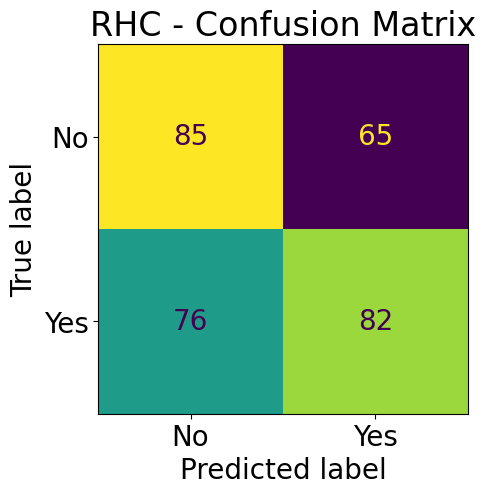

In [180]:
y_pred = rhc_train.predict(X_test_heart)
cm = confusion_matrix(y_test_heart, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No','Yes'],
                             )
disp.plot()
disp.im_.colorbar.remove()
plt.title('RHC - Confusion Matrix')
plt.show()

In [6]:
%%time

grid_search_ga = {
    "learning_rate_init": [0.001, 0.1, 0.5],
    "activation": [mlrose_hiive.neural.activation.relu],
    "population_sizes":[20,50,100,120,140],
    "keep_percent_list":[0.25, 0.5, 0.75], 
}

ga_nn = mlrose_hiive.NNGSRunner(X_train_heart, y_train_heart, 
                                 X_test_heart, y_test_heart, 
                                 experiment_name= "NeuralNetworkGA",
                                 output_directory="nn_ga_algorithm/",
                                 seed=42, iteration_list=[100000], 
                                 algorithm=mlrose_hiive.genetic_alg,
                                 hidden_layer_sizes=[[100, 100]],
                                 grid_search_parameters=grid_search_ga,
                                 grid_search_scorer_method=f1_score,
                                 early_stopping = True,
                                 max_attempts =100,
                                 generate_curves = True,
                                 n_jobs=-1,
                                 cv=5
                                )
run_stats_ga, curves_ga, cv_results_ga, best_est_ga = ga_nn.run()

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Wall time: 1h 28min 28s


In [23]:
best_est_ga.best_params_

{'activation': <function mlrose_hiive.neural.activation.relu.relu(x, deriv=False)>,
 'hidden_layer_sizes': [100, 100],
 'keep_percent_list': 0.25,
 'learning_rate_init': 0.001,
 'population_sizes': 20}

In [160]:
%%time
ga_nn_epochs = mlrose_hiive.NeuralNetwork(
    hidden_nodes = [100,100], activation = 'relu', 
    algorithm = 'genetic_alg', 
    max_iters=100000, 
    learning_rate =  0.001,
    early_stopping = True,
    max_attempts = 100,
    curve=True,
    random_state=42,
    pop_size= 20,
    mutation_prob = 0.25,
)
train_df_ga = pd.DataFrame([])
val_df_ga = pd.DataFrame([])

for i in range(5):
    print(i)
    X_train_train, X_test_train, y_train_train, y_test_train = train_test_split(X_train_heart, y_train_heart,
                                                        test_size = 0.2, random_state = (i+1)*i, stratify = y_train_heart
                                                       )

    ga_nn_epochs.fit(X_train_train, y_train_train)
    train_curve = ga_nn_epochs.fitness_curve[:,0]
    d = {i: train_curve}
    loss_df = pd.DataFrame(data=d)
    train_df_ga = pd.concat([train_df_ga,loss_df],1)
    ga_nn_epochs.fit(X_test_train, y_test_train)
    val_curve = ga_nn_epochs.fitness_curve[:,0]
    d = {i: val_curve}
    loss_df = pd.DataFrame(data=d)
    val_df_ga = pd.concat([val_df_ga,loss_df],1)

0
1
2
3
4
Wall time: 6min 32s


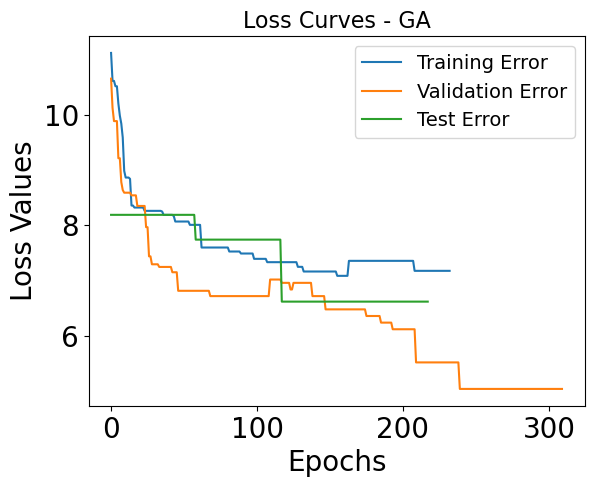

In [161]:
train_df_ga['Mean'] = train_df_ga.loc[:, [0,1,2,3,4]].mean(axis = 1)
val_df_ga['Mean'] = val_df_ga.loc[:, [0,1,2,3,4]].mean(axis = 1)
ax = plt.gca()
plt.plot(train_df_ga['Mean'],  label="Training Error")
plt.plot(val_df_ga['Mean'], label ='Validation Error')
plt.title('Loss Curves - '+ 'GA',fontsize = 16)
plt.xlabel("Epochs"), plt.ylabel("Loss Values"), plt.legend(loc="best",prop={'size': 14})
plt.show()

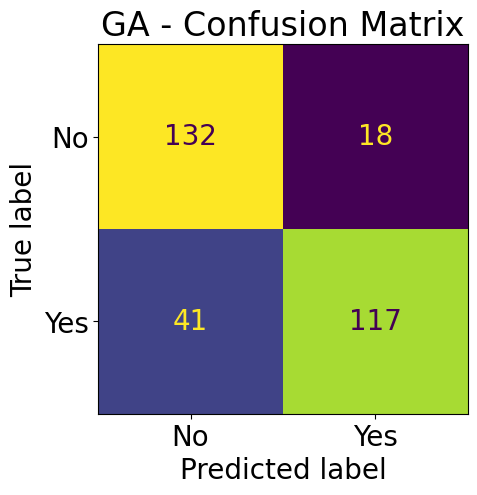

In [181]:
y_pred = ga_train.predict(X_test_heart)
cm = confusion_matrix(y_test_heart, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No','Yes'],
                             )
disp.plot()
disp.im_.colorbar.remove()
plt.title('GA - Confusion Matrix')
plt.show()

fit_time = 49.598451137542725
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       150
           1       0.82      0.79      0.81       158

    accuracy                           0.81       308
   macro avg       0.81      0.81      0.81       308
weighted avg       0.81      0.81      0.81       308

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       349
           1       0.79      0.80      0.79       368

    accuracy                           0.79       717
   macro avg       0.79      0.78      0.78       717
weighted avg       0.79      0.79      0.79       717

Wall time: 1min 21s


Text(0, 0.5, 'Loss')

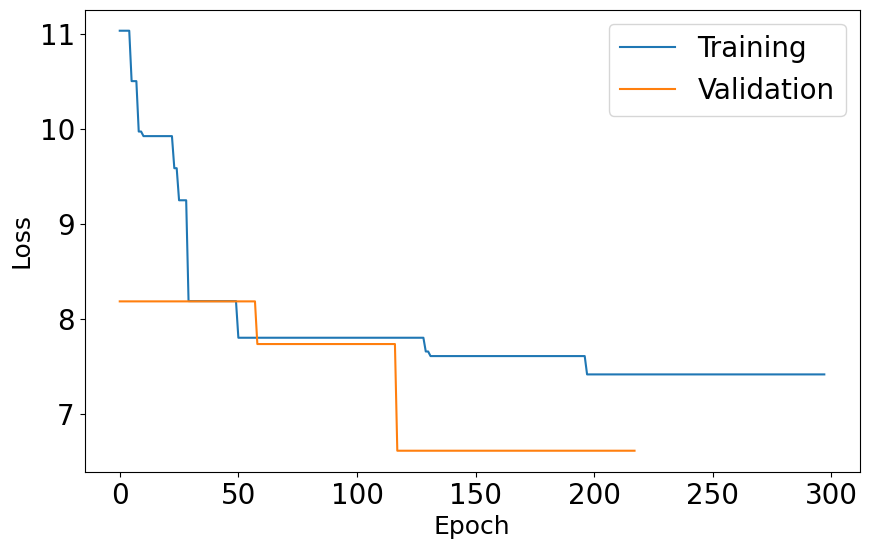

In [115]:
%%time
ga_nn_epochs = mlrose_hiive.NeuralNetwork(
    hidden_nodes = [100,100], activation = 'relu', 
    algorithm = 'genetic_alg', 
    max_iters=100000,
    learning_rate =  0.001,
    early_stopping = True,
    max_attempts = 100,
    curve=True,
    random_state=42,
    pop_size= 20,
    mutation_prob = 0.25,
)

time_start = time.time()
ga_train = ga_nn_epochs.fit(X_train_heart, y_train_heart)
fit_time = time.time()
print(f'fit_time = {fit_time-time_start}')
print(classification_report(y_test_heart, ga_nn_epochs.predict(X_test_heart)))
print(classification_report(y_train_heart, ga_nn_epochs.predict(X_train_heart)))
ga_test = plt.plot(ga_nn_epochs.fitness_curve[:,0],label='Training')
ga_nn_epochs.fit(X_test_heart, y_test_heart)
plt.plot(ga_nn_epochs.fitness_curve[:,0],label='Validation')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)

In [7]:
%%time

grid_search_sa = {
    "learning_rate_init": [0.001, 0.1, 0.5],
    "activation": [mlrose_hiive.neural.activation.relu],
    "schedule":[mlrose_hiive.GeomDecay(1), mlrose_hiive.GeomDecay(50), mlrose_hiive.GeomDecay(100),
                 mlrose_hiive.GeomDecay(250), mlrose_hiive.GeomDecay(300),
                 mlrose_hiive.ExpDecay(1), mlrose_hiive.ExpDecay(50), mlrose_hiive.ExpDecay(100),
                 mlrose_hiive.ExpDecay(250), mlrose_hiive.ExpDecay(300)
                                          ],
}

sa_nn = mlrose_hiive.NNGSRunner(X_train_heart, y_train_heart, 
                                 X_test_heart, y_test_heart, 
                                 experiment_name= "NeuralNetworkSA",
                                 output_directory="nn_sa_algorithm/",
                                 seed=42, iteration_list=[100000], 
                                 algorithm=mlrose_hiive.algorithms.sa.simulated_annealing,
                                 hidden_layer_sizes=[[100, 100]],
                                 grid_search_parameters=grid_search_sa,
                                 grid_search_scorer_method=f1_score,
                                 early_stopping = True,
                                 max_attempts =100,
                                 generate_curves = True,
                                 n_jobs=-1,
                                 cv=5
                                )
run_stats_sa, curves_sa, cv_results_sa, best_est_sa = sa_nn.run()

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Wall time: 41 s


In [10]:
best_est_sa.best_params_

{'activation': <function mlrose_hiive.neural.activation.relu.relu(x, deriv=False)>,
 'hidden_layer_sizes': [100, 100],
 'learning_rate_init': 0.1,
 'schedule': GeomDecay(init_temp=1, decay=0.99, min_temp=0.001)}

fit_time = 700.9663314819336
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       150
           1       0.94      0.89      0.92       158

    accuracy                           0.92       308
   macro avg       0.92      0.92      0.92       308
weighted avg       0.92      0.92      0.92       308

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       349
           1       0.95      0.96      0.95       368

    accuracy                           0.95       717
   macro avg       0.95      0.95      0.95       717
weighted avg       0.95      0.95      0.95       717

Wall time: 17min 10s


Text(0, 0.5, 'Loss')

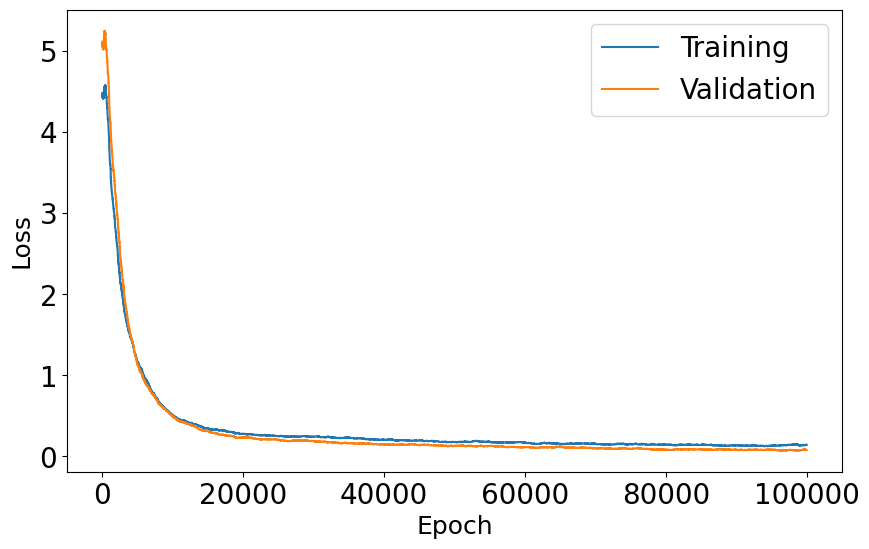

In [183]:
%%time
sa_nn_epochs = mlrose_hiive.NeuralNetwork(
    hidden_nodes = [100,100], activation = 'relu', 
    algorithm = 'simulated_annealing', 
    max_iters=100000,
    bias = True,
    is_classifier = True, 
    learning_rate =  0.1,
    early_stopping = True,
    max_attempts = 100,
    curve=True,
    random_state=42,
    schedule=mlrose_hiive.GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)
)

time_start = time.time()
sa_train = sa_nn_epochs.fit(X_train_heart, y_train_heart)
fit_time = time.time()
print(f'fit_time = {fit_time-time_start}')
print(classification_report(y_test_heart, sa_nn_epochs.predict(X_test_heart)))
print(classification_report(y_train_heart, sa_nn_epochs.predict(X_train_heart)))
plt.plot(sa_nn_epochs.fitness_curve[:,0],label='Training')
sa_test = sa_nn_epochs.fit(X_test_heart, y_test_heart)
plt.plot(sa_nn_epochs.fitness_curve[:,0],label='Validation')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)

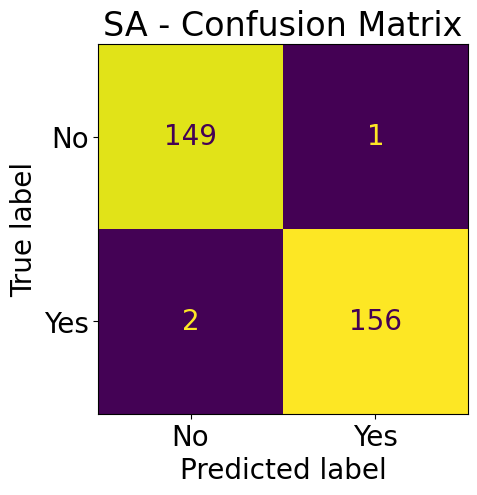

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.99      0.99      0.99       158

    accuracy                           0.99       308
   macro avg       0.99      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308



In [219]:
y_pred = sa_train.predict(X_test_heart)
cm = confusion_matrix(y_test_heart, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No','Yes'],
                             )
disp.plot()
disp.im_.colorbar.remove()
plt.title('SA - Confusion Matrix')
plt.show()
print(classification_report(y_test_heart, y_pred))

In [162]:
%%time
sa_nn_epochs = mlrose_hiive.NeuralNetwork(
    hidden_nodes = [100,100], activation = 'relu', 
    algorithm = 'simulated_annealing', 
    max_iters=100000,
    bias = True,
    is_classifier = True, 
    learning_rate =  0.1,
    early_stopping = True,
    max_attempts = 100,
    curve=True,
    random_state=42,
    schedule=mlrose_hiive.GeomDecay(1)
)

train_df_sa = pd.DataFrame([])
val_df_sa = pd.DataFrame([])

for i in range(5):
    print(i)
    X_train_train, X_test_train, y_train_train, y_test_train = train_test_split(X_train_heart, y_train_heart,
                                                        test_size = 0.2, random_state = (i+1)*i, stratify = y_train_heart
                                                       )

    sa_nn_epochs.fit(X_train_train, y_train_train)
    train_curve = sa_nn_epochs.fitness_curve[:,0]
    d = {i: train_curve}
    loss_df_train = pd.DataFrame(data=d)
    train_df_sa = pd.concat([train_df_sa,loss_df_train],1)
    sa_nn_epochs.fit(X_test_train, y_test_train)
    val_curve = sa_nn_epochs.fitness_curve[:,0]
    d = {i: val_curve}
    loss_df_val = pd.DataFrame(data=d)
    val_df_sa = pd.concat([val_df_sa,loss_df_val],1)

0
1
2
3
4
Wall time: 46min 50s


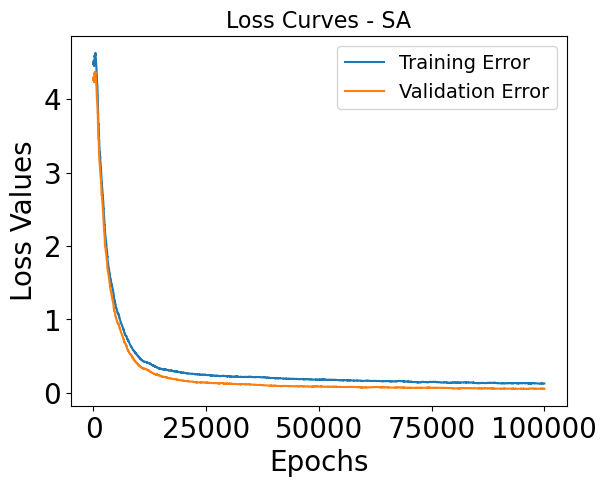

In [212]:
train_df_sa['Mean'] = train_df_sa.loc[:, [0,1,2,3,4]].mean(axis = 1)
val_df_sa['Mean'] = val_df_sa.loc[:, [0,1,2,3,4]].mean(axis = 1)

ax = plt.gca()
plt.plot(train_df_sa['Mean'],  label="Training Error")
plt.plot(val_df_sa['Mean'], label ='Validation Error')
plt.title('Loss Curves - '+ 'SA',fontsize = 16)
plt.xlabel("Epochs"), plt.ylabel("Loss Values"), plt.legend(loc="best",prop={'size': 14})

plt.show()

In [213]:
pipeline_heart = MLPClassifier(random_state=42, activation = "relu",alpha =0.001, hidden_layer_sizes=[100,100],solver='adam')
train_df = pd.DataFrame([])
val_df = pd.DataFrame([])
for i in range(5):
    X_train_train, X_test_train, y_train_train, y_test_train = train_test_split(X_train_heart, y_train_heart,
                                                        test_size = 0.2, random_state = (i+1)*i, stratify = y_train_heart
                                                       )
    time_start = time.time()
    pipeline_heart.fit(X_train_train, y_train_train)
    fit_time = time.time()
    print(f'fit_time = {fit_time-time_start}')
    train_curve = pipeline_heart.loss_curve_
    d = {i: train_curve}
    loss_df = pd.DataFrame(data=d)
    train_df = pd.concat([train_df,loss_df],1)
    pipeline_heart.fit(X_test_train, y_test_train)
    val_curve = pipeline_heart.loss_curve_
    d = {i: test_curve}
    loss_df = pd.DataFrame(data=d)
    val_df = pd.concat([val_df,loss_df],1)

fit_time = 0.7639114856719971
fit_time = 0.9787120819091797
fit_time = 0.8030455112457275
fit_time = 0.7557604312896729
fit_time = 0.7528367042541504


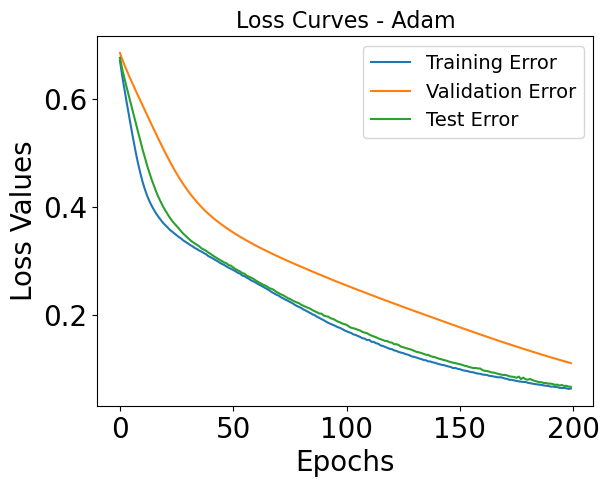

In [152]:
%%time
train_df['Mean'] = train_df.loc[:, [0,1,2,3,4]].mean(axis = 1)
val_df['Mean'] = val_df.loc[:, [0,1,2,3,4]].mean(axis = 1)
ax = plt.gca()
plt.plot(train_df['Mean'],  label="Training Error")
plt.plot(test_df['Mean'], label ='Validation Error')
pipeline_heart.fit(X_test_heart, y_test_heart)
plt.plot(pipeline_heart.loss_curve_, label ='Test Error')
plt.title('Loss Curves - '+ 'Adam',fontsize = 16)
plt.xlabel("Epochs"), plt.ylabel("Loss Values"), plt.legend(loc="best",prop={'size': 14})

plt.show()

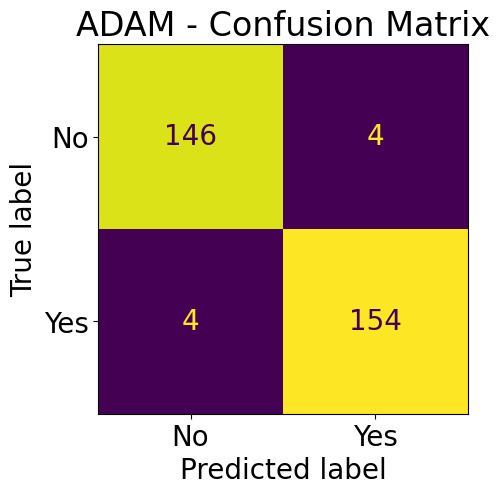

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       150
           1       0.97      0.97      0.97       158

    accuracy                           0.97       308
   macro avg       0.97      0.97      0.97       308
weighted avg       0.97      0.97      0.97       308



In [217]:
pipeline_heart = MLPClassifier(random_state=42, activation = "relu",alpha =0.001, hidden_layer_sizes=[100,100],solver='adam')
pipeline_heart.fit(X_train_heart, y_train_heart)
y_pred = pipeline_heart.predict(X_test_heart)
cm = confusion_matrix(y_test_heart, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No','Yes'],
                             )
disp.plot()
disp.im_.colorbar.remove()
plt.title('ADAM - Confusion Matrix')
plt.show()
print(classification_report(y_test_heart, y_pred))

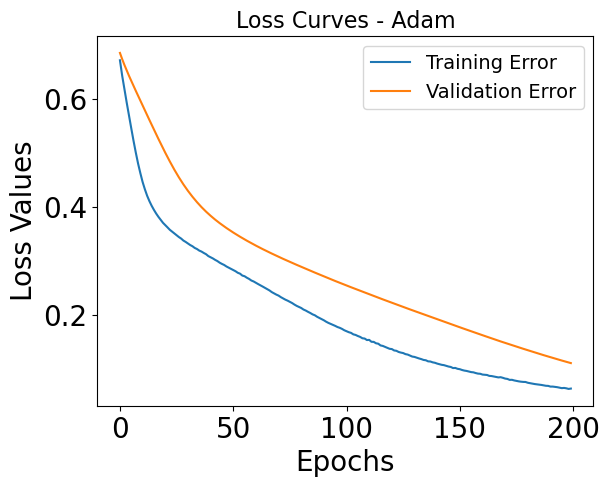

In [211]:
ax = plt.gca()
plt.plot(train_df['Mean'],  label="Training Error")
plt.plot(test_df['Mean'], label ='Validation Error')
plt.title('Loss Curves - '+ 'Adam',fontsize = 16)
plt.xlabel("Epochs"), plt.ylabel("Loss Values"), plt.legend(loc="best",prop={'size': 14})

plt.show()

KeyError: 'Mean'

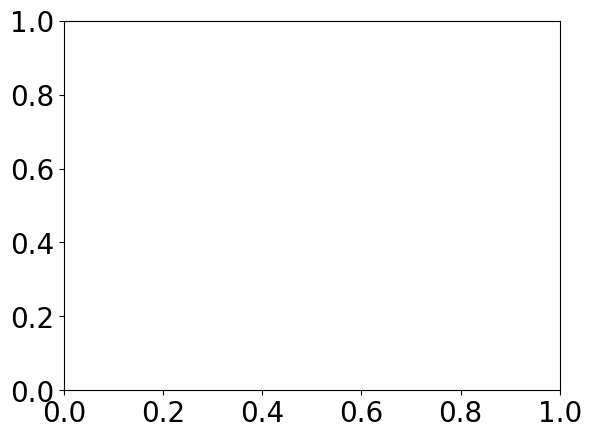

In [214]:
ax = plt.gca()
plt.plot(train_df['Mean'],  label=" Training - Adam", color ='blue')
plt.plot(test_df['Mean'], '--',  label=" Val - Adam", color ='blue')
plt.plot(rhc_train.fitness_curve[:,0], label ='Training - RHC', color ='orange')
plt.plot(rhc_test.fitness_curve[:,0], '--', label ='Val - RHC', color ='orange')
plt.plot(train_df_ga['Mean'], label ='Training - GA', color ='green')
plt.plot(val_df_ga['Mean'], '--', label ='Val - GA', color ='green')
plt.plot(train_df_sa['Mean'], label ='Training - SA', color ='red')
plt.plot(val_df_sa['Mean'], '--', label ='Val - SA', color ='red')
plt.title('Loss Curves',fontsize = 16)
plt.xlabel("Epochs"), plt.ylabel("Loss Values"), plt.legend(loc="upper right",prop={'size': 12})
plt.xscale('log',base=10) 

plt.show()